# MUTI CLASIFICATION LUNG

In [80]:
# !pip install -r requirements.txt

In [81]:
import pandas as pd
import random
import numpy as np
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import os
import shutil
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch import device
from torchvision import transforms

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoImageProcessor, ViTForImageClassification

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

## LOAD DATASET

In [82]:
# Load train and validation data
df = pd.read_csv('lung_dataset/dataset.csv')

if 'df' in locals():
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [83]:
# Display first 5 rows of validation data
df.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223643,lung_dataset/image/patient223644.jpg,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223644,lung_dataset/image/patient223645.jpg,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223645,lung_dataset/image/patient223646.jpg,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223646,lung_dataset/image/patient223647.jpg,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223647,lung_dataset/image/patient223648.jpg,Male,90,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [84]:
df.describe()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223648.000000,22615.000000,45073.000000,46437.000000,118012.000000,12178.000000,86190.000000,70856.000000,27842.000000,68677.000000,79168.000000,133445.000000,6726.000000,12428.000000,123451.000000
mean,60.431030,0.991333,-0.033191,0.408747,0.848295,0.632206,0.456051,-0.182426,-0.456971,-0.004121,0.206030,0.559227,0.129497,0.675732,0.931779
std,17.821668,0.092693,0.718381,0.768105,0.472826,0.690605,0.741190,0.753230,0.826168,0.989150,0.492987,0.648667,0.949600,0.567855,0.284690
min,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,49.000000,1.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
50%,62.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,74.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = df.loc[:, ~df.columns.isin(['Path'])].nunique()
unique_values = df.loc[:, ~df.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values.apply(lambda x: ', '.join(x))})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count  \
Sex                                    3   
Age                                   74   
Frontal/Lateral                        2   
AP/PA                                  4   
No Finding                             2   
Enlarged Cardiomediastinum             3   
Cardiomegaly                           3   
Lung Opacity                           3   
Lung Lesion                            3   
Edema                                  3   
Consolidation                          3   
Pneumonia                              3   
Atelectasis                            3   
Pneumothorax                           3   
Pleural Effusion                       3   
Pleural Other                          3   
Fracture                               3   
Support Devices                        3   

                                                                Unique Values  
Sex               

### Check nilai ambigu (-1.0)

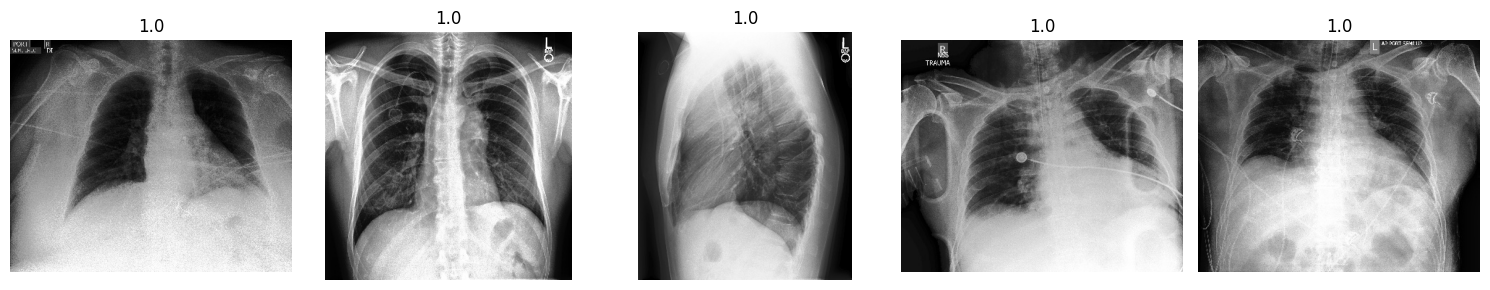

In [86]:
# Ambil 5 baris dari train_df yang label 'Support Devices' bernilai -1.0
support_device_neg1 = df[df['Support Devices'] == 1.0].head(5)

plt.figure(figsize=(15, 3))
for i, (_, row) in enumerate(support_device_neg1.iterrows()):
    img_path = row['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{row['Support Devices']}")
plt.tight_layout()
plt.show()

>Dari hasil penelitian diatas bahwa uncurtain (-1.0) pada `'Support Devices'` cenderung positive (1.0). peneliti melabeli uncertain karena bahwa kondisi yang ada digambar tidak tampak terlihat jelas

### Check imbalance data

In [87]:
# Ubah semua nilai -1.0 menjadi 1.0 pada kolom label di train_df dan valid_df
label_cols = ['No Finding', 
              'Enlarged Cardiomediastinum', 
              'Cardiomegaly', 
              'Lung Opacity', 
              'Lung Lesion', 
              'Edema', 
              'Consolidation', 
              'Pneumonia', 
              'Atelectasis', 
              'Pneumothorax', 
              'Pleural Effusion', 
              'Pleural Other', 
              'Fracture', 
              'Support Devices']

imbalance_check = df[label_cols].replace(-1.0, 1.0)

### distribusi data

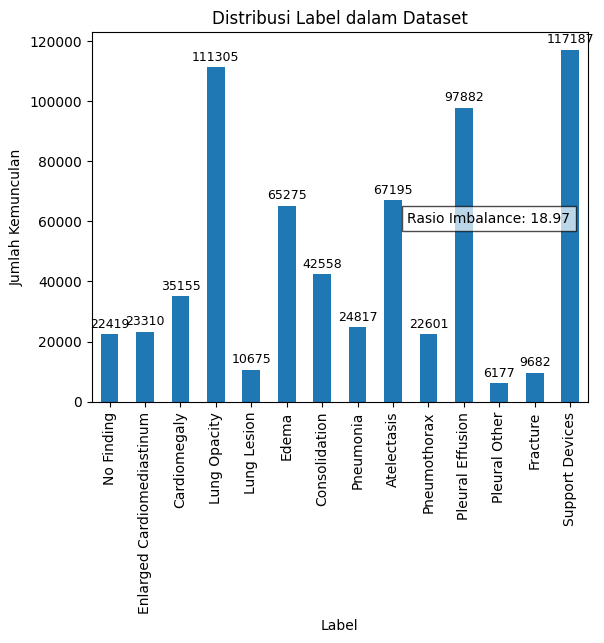

In [88]:
# Ambil 14 label terakhir dari kolom train_df dan valid_df, hitung distribusi label (jumlah 1.0)
label_counts = (imbalance_check == 1.0).sum()

# print("Distribusi Label:")
# print(label_counts)

max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

ax = label_counts.plot(kind='bar')
plt.title('Distribusi Label dalam Dataset')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')

# Tambahkan teks jumlah di atas setiap bar
for i, v in enumerate(label_counts):
    ax.text(i, v + max_count * 0.01, str(v), ha='center', va='bottom', fontsize=9, rotation=0)

# Tambahkan teks rasio imbalance di dalam grafik (pada sumbu y tertinggi)
plt.text(
    x=len(label_counts) - 1, 
    y=max_count - max_count * 0.5, 
    s=f'Rasio Imbalance: {imbalance_ratio:.2f}', 
    ha='right', va='bottom', fontsize=10, 
    bbox=dict(facecolor='white', alpha=0.7)
)
plt.savefig('document/distribusi_label_rawdf.png')
plt.show()

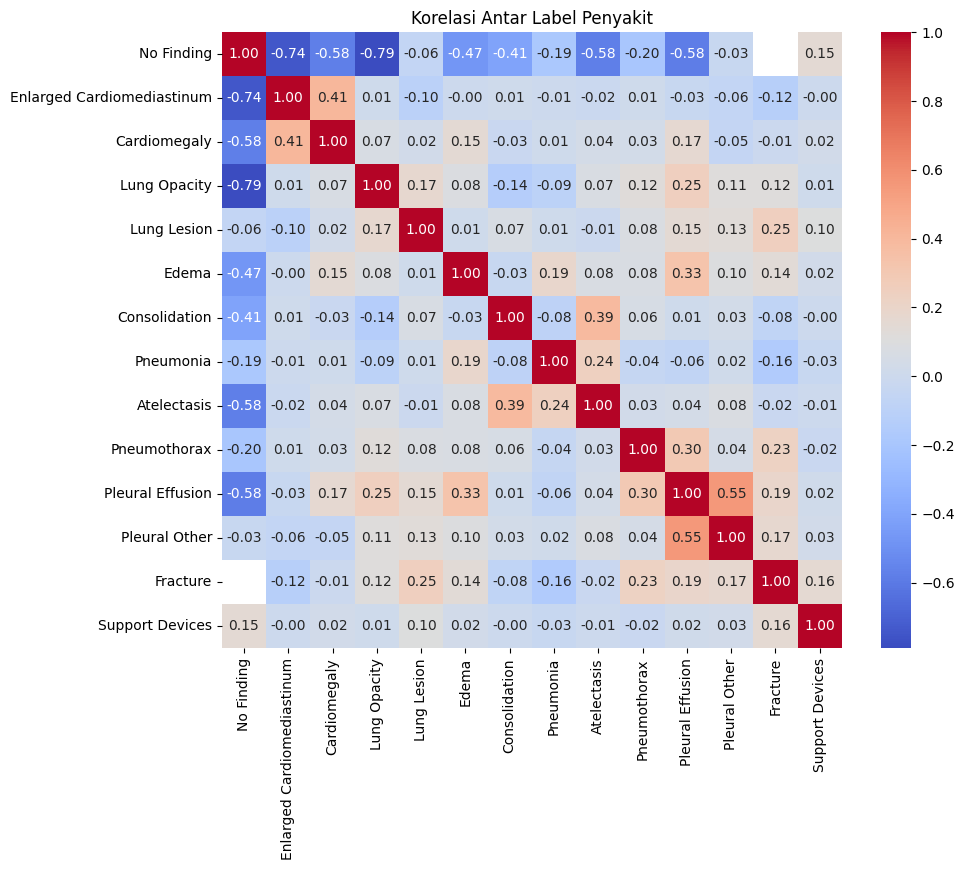

In [89]:
import seaborn as sns

# Menghitung korelasi antar label penyakit pada dataframe df
correlation_matrix = df[label_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Label Penyakit")
plt.savefig('document/korelasi_rawdf.png')
plt.show()

## PRE PROSESING OLD DATA

FIlter Range Data `age`

### Inisialisasi label

In [90]:
label_cols = [
    'Enlarged Cardiomediastinum', 
    'Cardiomegaly',
    'Lung Opacity', 
    'Lung Lesion', 
    'Edema', 
    'Consolidation',
    'Pneumonia',
    'Atelectasis', 
    'Pneumothorax', 
    'Pleural Effusion',
    # 'Pleural Other',
    'Fracture',
    # 'Support Devices'
]

# Hapus kolom yang tidak diperlukan
columns_to_drop = [
    'Sex', 
    'Age', 
    'Frontal/Lateral', 
    'AP/PA',
    'No Finding',
    # 'Enlarged Cardiomediastinum', 
    # 'Cardiomegaly',
    # 'Lung Opacity', 
    # 'Lung Lesion', 
    # 'Edema', 
    # 'Consolidation',
    # 'Pneumonia',
    # 'Atelectasis', 
    # 'Pneumothorax', 
    # 'Pleural Effusion',
    'Pleural Other',
    # 'Fracture',
    'Support Devices'
    ]

### Drop data

In [91]:
# jumlah data sebelum penghapusan
jumlah_data_sebelum = df.shape[0]
print(f"Jumlah data sebelum penghapusan: {jumlah_data_sebelum}")

#drop baris dimana kolom 'Frontal/Lateral' bernilai 'Lateral'
df = df.drop(df[df['Frontal/Lateral'] == 'Lateral'].index)

#jumlah data setelah penghapusan
jumlah_data_setelah = df.shape[0]
print(f"Jumlah data setelah penghapusan: {jumlah_data_setelah}")

Jumlah data sebelum penghapusan: 223648
Jumlah data setelah penghapusan: 191229


In [92]:
df = df.drop(columns=columns_to_drop)

print(f"Kolom {columns_to_drop} yang tidak diperlukan telah dihapus.")

Kolom ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Pleural Other', 'Support Devices'] yang tidak diperlukan telah dihapus.


### modifikasi nilai ambigu

In [93]:
df = df[~(df[label_cols] == -1.0).any(axis=1)].replace(-1.0, 1.0)

print(f"Jumlah data setelah mengubah nilai -1.0 menjadi 1.0 di kolom label: {df.shape[0]}")

Jumlah data setelah mengubah nilai -1.0 menjadi 1.0 di kolom label: 119276


### Modifikasi label

In [94]:
# Membuat dataset baru untuk train_df: path -> [label1, label2, ...] hanya untuk label dengan nilai 1.0
label_columns_temp = df.columns[1:]  # kolom label (kecuali 'Path')
df2 = []
for idx, row in df.iterrows():
    labels = [col for col in label_columns_temp if row[col] == 1.0]
    df2.append({
        'Path': row['Path'], 
        'Labels': labels})

# Contoh hasil
print("Contoh df2:")
for item in df2[:20]:
    print(f"{item['Path']} : {item['Labels']}")

del label_columns_temp

Contoh df2:
lung_dataset/image/patient00001.jpg : []
lung_dataset/image/patient00005.jpg : ['Edema']
lung_dataset/image/patient00006.jpg : []
lung_dataset/image/patient00008.jpg : []
lung_dataset/image/patient00010.jpg : ['Pneumothorax']
lung_dataset/image/patient00011.jpg : ['Pneumothorax']
lung_dataset/image/patient00012.jpg : []
lung_dataset/image/patient00013.jpg : ['Cardiomegaly', 'Lung Opacity', 'Atelectasis', 'Pneumothorax']
lung_dataset/image/patient00014.jpg : ['Enlarged Cardiomediastinum', 'Lung Opacity', 'Atelectasis']
lung_dataset/image/patient00015.jpg : ['Lung Opacity', 'Pleural Effusion']
lung_dataset/image/patient00016.jpg : ['Lung Opacity', 'Pleural Effusion']
lung_dataset/image/patient00017.jpg : ['Cardiomegaly', 'Atelectasis']
lung_dataset/image/patient00019.jpg : []
lung_dataset/image/patient00021.jpg : []
lung_dataset/image/patient00024.jpg : ['Lung Opacity', 'Pneumothorax']
lung_dataset/image/patient00025.jpg : ['Lung Opacity']
lung_dataset/image/patient00027.jpg 

## PRE PROSESING NEW DATA

### FIltering outlayer image

In [95]:
# from tqdm import tqdm

# # Plot distribusi rata-rata intensitas piksel untuk setiap gambar di

# import matplotlib.pyplot as plt

# mean_intensities = []
# paths = []

# for item in tqdm(df2, desc="Menghitung intensitas rata-rata"):
#     img_path = item['Path']
#     try:
#         img = Image.open(img_path).convert('L')
#         mean_intensity = img.resize((32, 32)).getdata()
#         mean_intensity = sum(mean_intensity) / len(mean_intensity)
#         mean_intensities.append(mean_intensity)
#         paths.append(img_path)
#     except Exception as e:
#         mean_intensities.append(None)
#         paths.append(img_path)

In [96]:
# plt.figure(figsize=(12, 5))
# # Warnai titik-titik: merah jika <100 atau >135, biru jika di antara
# intensity_threshold_low = 95
# intensity_threshold_high = 134
# colors = ['red' if (v is not None and (v < intensity_threshold_low or v > intensity_threshold_high)) else 'blue' for v in mean_intensities]
# plt.scatter(range(len(mean_intensities)), mean_intensities, c=colors, alpha=0.3, s=1)
# plt.plot(mean_intensities, '.', alpha=0.3, markersize=1)

# # Tambahkan garis batas
# plt.axhline(y=intensity_threshold_low, color='green', linestyle='--', linewidth=0.5, label='Batas Bawah (100)')
# plt.axhline(y=intensity_threshold_high, color='green', linestyle='--', linewidth=0.5, label='Batas Atas (135)')

# plt.title('Distribusi Rata-rata Intensitas Piksel pada Setiap Gambar')
# plt.xlabel('Index Gambar')
# plt.ylabel('Rata-rata Intensitas (0-255)')
# plt.legend()
# #plt.tight_layout()
# plt.savefig('document/outlier_intensity_analysis.png')
# plt.show()

In [97]:
# # Buat direktori output jika belum ada
# outlier_dir = "outlier_image"
# os.makedirs(outlier_dir, exist_ok=True)

# outlier_count = 0
# outlier_paths = []
# for item in df2:
#     img_path = item['Path']
#     try:
#         img = Image.open(img_path).convert('L')  # grayscale
#         #img = center_crop(img)      # crop tengah sebelum filter
#         mean_intensity = img.resize((32, 32)).getdata()
#         mean_intensity = sum(mean_intensity) / len(mean_intensity)
#         if mean_intensity >= intensity_threshold_high or mean_intensity <= intensity_threshold_low:
#             #shutil.copy(img_path, os.path.join(outlier_dir, os.path.basename(img_path)))
#             outlier_count += 1
#             outlier_paths.append(img_path)  # Catat path gambar outlier

#             print(f"Outlier detected: {img_path} with mean intensity {mean_intensity:.1f}")

#     except Exception as e:
#         print(f"Error processing {img_path}: {e}")

# print(f"Jumlah gambar outlier yang disalin: {outlier_count}")

# # Pastikan direktori 'document' ada
# os.makedirs('document', exist_ok=True)

# # Simpan daftar path gambar outlier ke file document/outlier.txt
# with open('document/outlier.txt', 'w') as f:
#     for path in outlier_paths:
#         f.write(f"{path}\n")
# print(f"Daftar outlier disimpan ke document/outlier.txt")

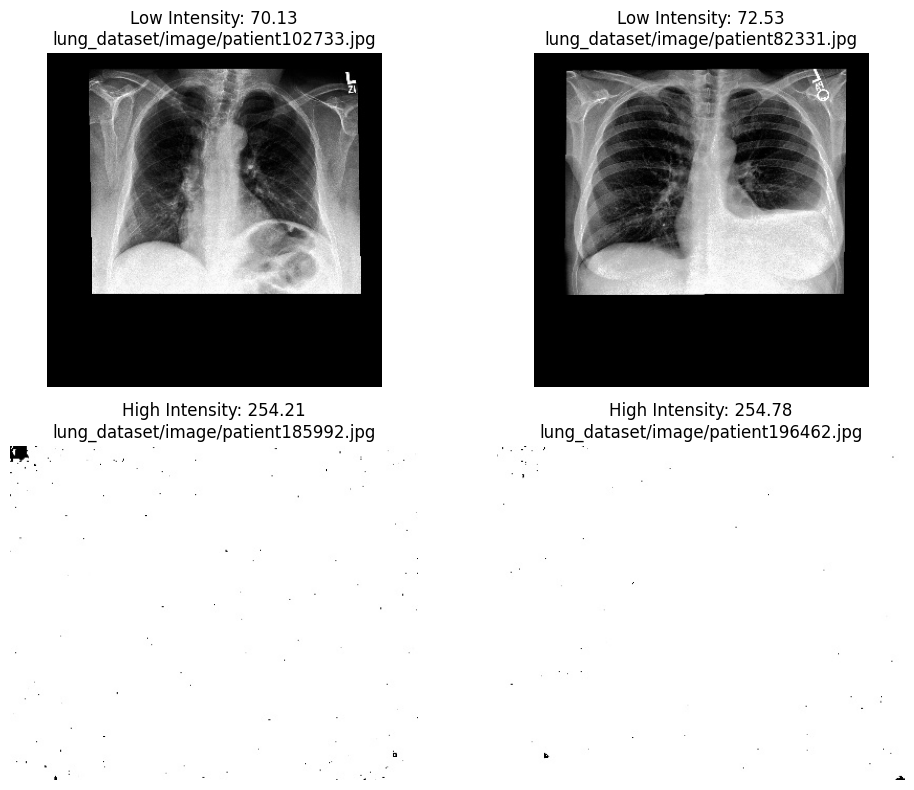

In [98]:
# Baca file outlier.txt untuk mendapatkan daftar path gambar
with open("document/outlier.txt", "r") as file:
    image_paths = file.read().splitlines()

# Inisialisasi list untuk menyimpan intensitas dan gambar
image_data = []

# Loop melalui setiap path gambar
for path in image_paths:
    # Baca gambar dalam mode grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Hitung rata-rata intensitas piksel
        avg_intensity = np.mean(img)
        image_data.append((path, img, avg_intensity))
    else:
        print(f"Gambar tidak dapat dibaca: {path}")

# Jika ada gambar yang terbaca
if image_data:
    # Urutkan berdasarkan intensitas (dari rendah ke tinggi)
    image_data_sorted = sorted(image_data, key=lambda x: x[2])

    # Ambil 2 terendah dan 2 tertinggi
    lowest_images = image_data_sorted[:2]  # 2 terendah
    highest_images = image_data_sorted[-2:]  # 2 tertinggi

    # Gabungkan untuk ditampilkan (low1, low2, high1, high2)
    display_images = lowest_images + highest_images

    # Buat plot 2x2
    plt.figure(figsize=(10, 8))

    for i, (path, img, intensity) in enumerate(display_images, 1):
        plt.subplot(2, 2, i)
        plt.imshow(img, cmap='gray')
        plt.title(f"{'Low' if i <= 2 else 'High'} Intensity: {intensity:.2f}\n{path}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('document/outlier_intensity_analysis.png')
    plt.show()
    
else:
    print("Tidak ada gambar yang dapat diproses.")

In [99]:
# Baca daftar path outlier dari file
with open('document/outlier.txt', 'r') as f:
    outlier_paths = set(line.strip() for line in f if line.strip())

# Buat list baru tanpa data outlier
df2_clean = [item for item in df2 if item['Path'] not in outlier_paths]

print(f"Jumlah data sebelum dihapus outlier: {len(df2)}")
print(f"Jumlah data setelah dihapus outlier: {len(df2_clean)}")

Jumlah data sebelum dihapus outlier: 119276
Jumlah data setelah dihapus outlier: 119124


### split dataset

In [100]:
# Split combined_df menjadi train (60%), validasi (20%), test (20%)
# Split combined_df2 (list of dict) menjadi train/valid/test dengan proporsi 60/20/20

train_df, temp_df = train_test_split(df2, test_size=0.4, random_state=42, shuffle=True)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

# Untuk konsistensi dengan variabel sebelumnya, hapus variabel list sementara
del df2
del temp_df

print(f"train_df shape: {len(train_df)}") #60
print(f"valid_df shape: {len(valid_df)}") #20
print(f"test_df shape: {len(test_df)}") #20

train_df shape: 71565
valid_df shape: 23855
test_df shape: 23856


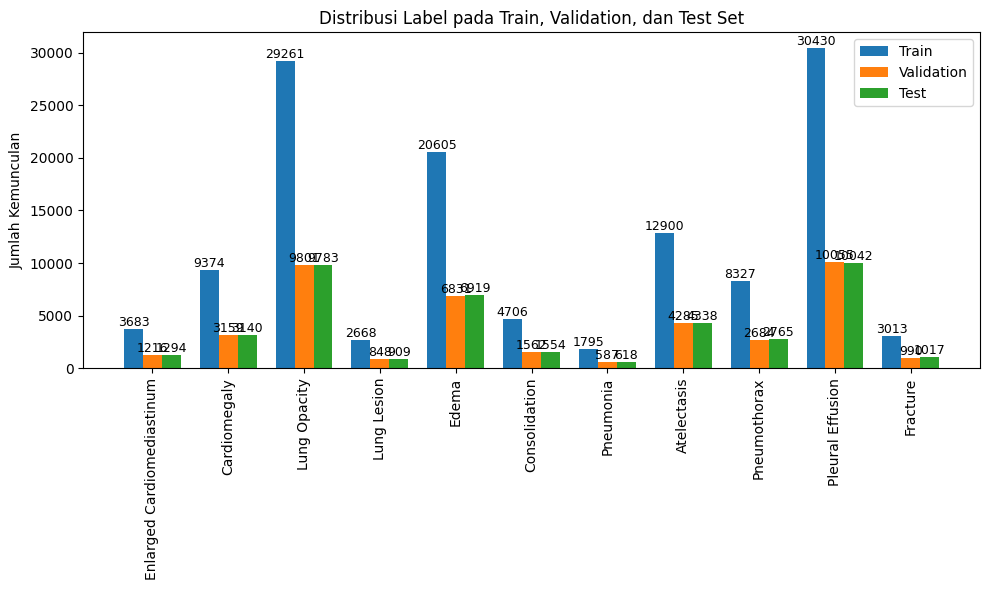

In [101]:
# Plot distribusi jumlah label pada train_df, valid_df, dan test_df

def multilabel_counts(data_list, label_columns):
    counts = {label: 0 for label in label_columns}
    for item in data_list:
        for label in item['Labels']:
            if label in counts:
                counts[label] += 1
    return counts

train_counts = multilabel_counts(train_df, label_cols)
valid_counts = multilabel_counts(valid_df, label_cols)
test_counts = multilabel_counts(test_df, label_cols)

x = np.arange(len(label_cols))
width = 0.25

plt.figure(figsize=(10, 6))
bars_train = plt.bar(x - width, [train_counts[l] for l in label_cols], width, label='Train')
bars_valid = plt.bar(x, [valid_counts[l] for l in label_cols], width, label='Validation')
bars_test = plt.bar(x + width, [test_counts[l] for l in label_cols], width, label='Test')

# Tambahkan teks jumlah data di atas setiap bar
for bars in [bars_train, bars_valid, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=9)

plt.xticks(x, label_cols, rotation=90)
plt.ylabel('Jumlah Kemunculan')
plt.title('Distribusi Label pada Train, Validation, dan Test Set')
plt.legend()
plt.tight_layout()
plt.savefig('document/distribusi_label.png')
plt.show()

### balancing data

#### potong data

In [102]:
def balance_multilabel_list(data_list, label_columns, max_per_label, random_state=42):
    # Inisialisasi penghitung label
    label_counter = {label: 0 for label in label_columns}
    balanced_data = []

    # Shuffle dataset untuk menghindari urutan bias
    random.seed(random_state)
    shuffled = data_list.copy()
    random.shuffle(shuffled)

    for item in shuffled:
        labels = [label for label in item['Labels'] if label in label_columns]
        if all(label_counter[label] < max_per_label for label in labels):
            balanced_data.append(item)
            for label in labels:
                label_counter[label] += 1
        if all(count >= max_per_label for count in label_counter.values()):
            break

    return balanced_data

###############################################

# Gunakan fungsi balancing
train_df = balance_multilabel_list(train_df, label_columns=label_cols, max_per_label=6000)
valid_df = balance_multilabel_list(valid_df, label_columns=label_cols, max_per_label=2000)

In [104]:
from collections import Counter

def get_label_tuple(labels, all_labels):
    # Mengubah list label menjadi tuple biner sesuai urutan all_labels
    return tuple(int(label in labels) for label in all_labels)

def balance_multilabel_combinations(data_list, label_columns, min_per_comb=100, random_state=42):
    random.seed(random_state)
    # Hitung frekuensi kombinasi label
    comb_counter = Counter(get_label_tuple(item['Labels'], label_columns) for item in data_list)
    balanced_data = []
    for comb, count in comb_counter.items():
        samples = [item for item in data_list if get_label_tuple(item['Labels'], label_columns) == comb]
        if count < min_per_comb:
            # Oversample kombinasi yang jarang
            samples = samples * (min_per_comb // count) + random.choices(samples, k=min_per_comb % count)
        balanced_data.extend(samples)
    return balanced_data

# Ganti pemanggilan balancing
train_df = balance_multilabel_combinations(train_df, label_columns=label_cols, min_per_comb=50)
valid_df = balance_multilabel_combinations(valid_df, label_columns=label_cols, min_per_comb=50)

/tmp/ipykernel_30/3043019737.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(train_label_counts.keys(), rotation=90)
/tmp/ipykernel_30/3043019737.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(valid_label_counts.keys(), rotation=90)


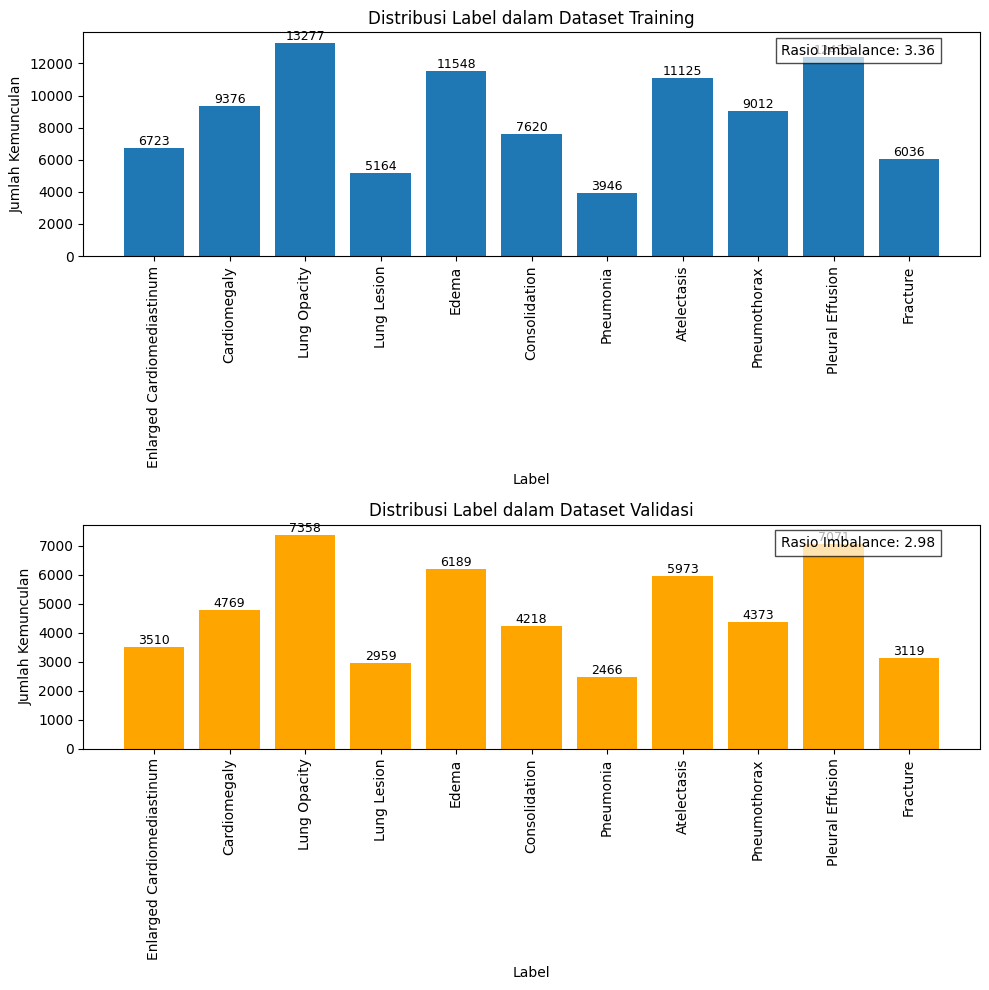

In [105]:
# Hitung distribusi label
def multilabel_counts(data_list, label_columns):
    counts = {label: 0 for label in label_columns}
    for item in data_list:
        for label in item['Labels']:
            if label in counts:
                counts[label] += 1
    return counts

train_label_counts = multilabel_counts(train_df, label_cols)
valid_label_counts = multilabel_counts(valid_df, label_cols)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot untuk training
bars_train = axs[0].bar(train_label_counts.keys(), train_label_counts.values())
axs[0].set_title('Distribusi Label dalam Dataset Training')
axs[0].set_ylabel('Jumlah Kemunculan')
axs[0].set_xlabel('Label')

for bar in bars_train:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom', fontsize=9)

axs[0].set_xticklabels(train_label_counts.keys(), rotation=90)
train_ratio = max(train_label_counts.values()) / max(1, min(train_label_counts.values()))
axs[0].text(0.95, 0.95, f'Rasio Imbalance: {train_ratio:.2f}', 
            transform=axs[0].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Plot untuk validasi
bars_valid = axs[1].bar(valid_label_counts.keys(), valid_label_counts.values(), color='orange')
axs[1].set_title('Distribusi Label dalam Dataset Validasi')
axs[1].set_ylabel('Jumlah Kemunculan')
axs[1].set_xlabel('Label')

for bar in bars_valid:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom', fontsize=9)

axs[1].set_xticklabels(valid_label_counts.keys(), rotation=90)
valid_ratio = max(valid_label_counts.values()) / max(1, min(valid_label_counts.values()))
axs[1].text(0.95, 0.95, f'Rasio Imbalance: {valid_ratio:.2f}', 
            transform=axs[1].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('document/distribusi_label_balancing.png')
plt.show()

### hapus label under 50%

In [123]:
from collections import Counter

# Hitung min_count sebagai 50% dari jumlah maksimum label
min_count = int(max(train_label_counts.values()) * 0.5)
# Hitung jumlah data per label pada df2_clean

# Hitung jumlah data per label pada df2_clean
label_counter = Counter()
for item in train_df:
    label_counter.update(item['Labels'])

# Ambil label yang jumlahnya >= min_count
labels_to_keep = [label for label, count in label_counter.items() if count >= min_count]
print(f"Label yang dipertahankan (>= {min_count} data): {labels_to_keep}")

# Hapus kolom label yang tidak dipertahankan dari setiap item
filtered_train_df = []
for item in train_df:
    filtered_labels = [label for label in item['Labels'] if label in labels_to_keep]
    # Tetap tambahkan row, meskipun labelnya kosong
    filtered_train_df.append({'Path': item['Path'], 'Labels': filtered_labels})

filtered_valid_df = []
for item in valid_df:
    filtered_labels = [label for label in item['Labels'] if label in labels_to_keep]
    # Tetap tambahkan row, meskipun labelnya kosong
    filtered_valid_df.append({'Path': item['Path'], 'Labels': filtered_labels})

filtered_test_df = []
for item in test_df:
    filtered_labels = [label for label in item['Labels'] if label in labels_to_keep]
    # Tetap tambahkan row, meskipun labelnya kosong
    filtered_test_df.append({'Path': item['Path'], 'Labels': filtered_labels})

print(f"Jumlah data train_df: {len(train_df)} menjadi {len(filtered_train_df)}")
print(f"Jumlah data valid_df: {len(valid_df)} menjadi {len(filtered_valid_df)}")
print(f"Jumlah data test_df: {len(test_df)} menjadi {len(filtered_test_df)}")
print(f"Label yang digunakan: {labels_to_keep}")

Label yang dipertahankan (>= 6638 data): ['Lung Opacity', 'Pleural Effusion', 'Pneumothorax', 'Edema', 'Atelectasis', 'Cardiomegaly', 'Enlarged Cardiomediastinum', 'Consolidation']
Jumlah data train_df: 49864 menjadi 49864
Jumlah data valid_df: 22930 menjadi 22930
Jumlah data test_df: 23856 menjadi 23856
Label yang digunakan: ['Lung Opacity', 'Pleural Effusion', 'Pneumothorax', 'Edema', 'Atelectasis', 'Cardiomegaly', 'Enlarged Cardiomediastinum', 'Consolidation']


/tmp/ipykernel_30/2846476697.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(train_label_counts.keys(), rotation=90)
/tmp/ipykernel_30/2846476697.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(valid_label_counts.keys(), rotation=90)
/tmp/ipykernel_30/2846476697.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(test_label_counts.keys(), rotation=90)


Text(0.95, 0.95, 'Rasio Imbalance: 7.76')

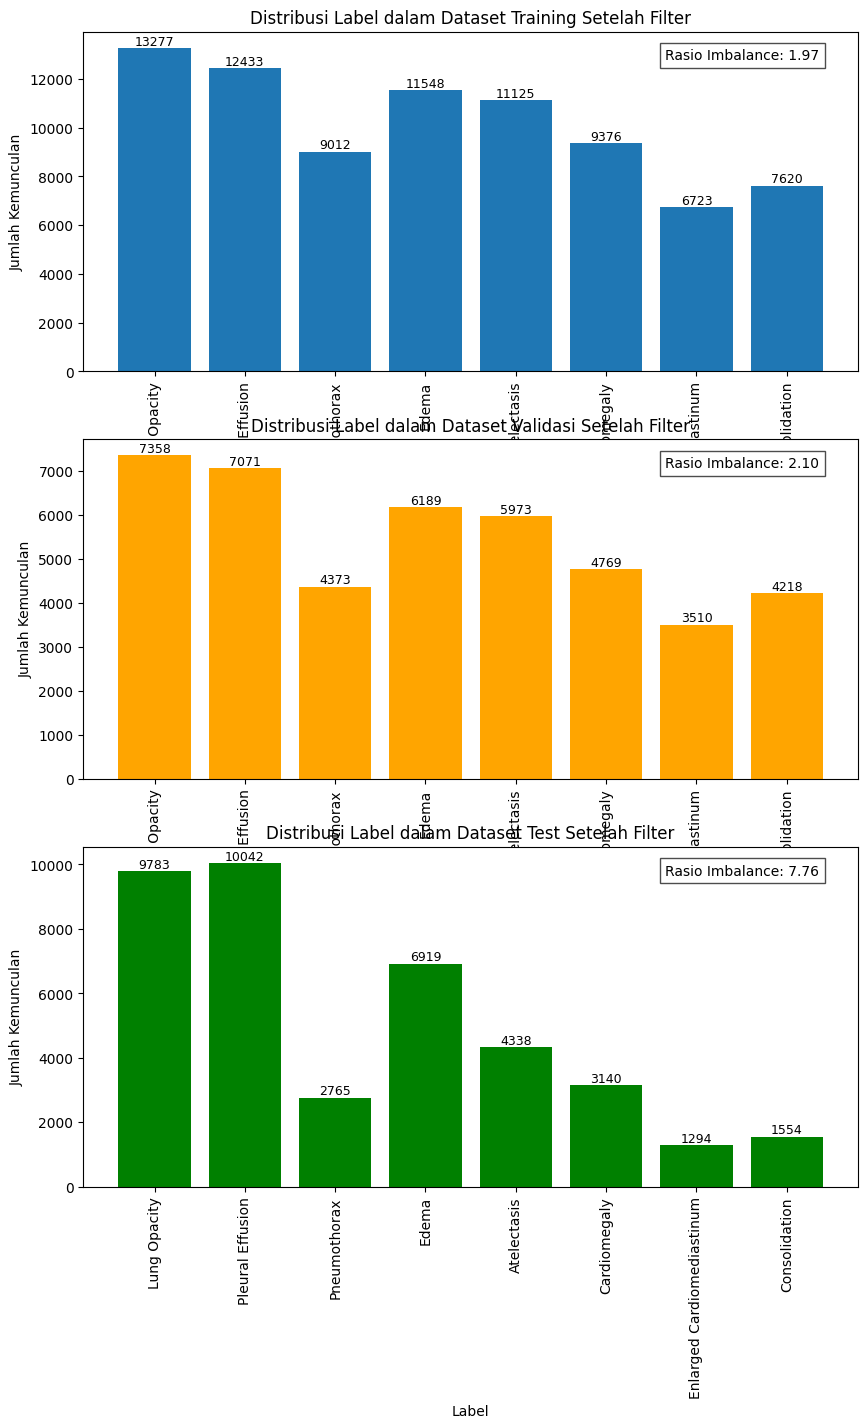

In [131]:
#distribusi label setelah filter
train_label_counts = multilabel_counts(filtered_train_df, labels_to_keep)
valid_label_counts = multilabel_counts(filtered_valid_df, labels_to_keep)
test_label_counts = multilabel_counts(filtered_test_df, labels_to_keep)

# Plot distribusi label setelah filter
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
# Plot untuk training
bars_train = axs[0].bar(train_label_counts.keys(), train_label_counts.values())
axs[0].set_title('Distribusi Label dalam Dataset Training Setelah Filter')
axs[0].set_ylabel('Jumlah Kemunculan')
axs[0].set_xlabel('Label')
for bar in bars_train:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom', fontsize=9)
axs[0].set_xticklabels(train_label_counts.keys(), rotation=90)
train_ratio = max(train_label_counts.values()) / max(1, min(train_label_counts.values()))
axs[0].text(0.95, 0.95, f'Rasio Imbalance: {train_ratio:.2f}',
            transform=axs[0].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Plot untuk validasi
bars_valid = axs[1].bar(valid_label_counts.keys(), valid_label_counts.values(), color='orange')
axs[1].set_title('Distribusi Label dalam Dataset Validasi Setelah Filter')
axs[1].set_ylabel('Jumlah Kemunculan')
axs[1].set_xlabel('Label')
for bar in bars_valid:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom', fontsize=9)
axs[1].set_xticklabels(valid_label_counts.keys(), rotation=90)
valid_ratio = max(valid_label_counts.values()) / max(1, min(valid_label_counts.values()))
axs[1].text(0.95, 0.95, f'Rasio Imbalance: {valid_ratio:.2f}',
            transform=axs[1].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Plot untuk test
bars_test = axs[2].bar(test_label_counts.keys(), test_label_counts.values(), color='green')
axs[2].set_title('Distribusi Label dalam Dataset Test Setelah Filter')
axs[2].set_ylabel('Jumlah Kemunculan')
axs[2].set_xlabel('Label')
for bar in bars_test:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom', fontsize=9)
axs[2].set_xticklabels(test_label_counts.keys(), rotation=90)
test_ratio = max(test_label_counts.values()) / max(1, min(test_label_counts.values()))
axs[2].text(0.95, 0.95, f'Rasio Imbalance: {test_ratio:.2f}',
            transform=axs[2].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))                

## Hasil Pre-procesing

In [132]:
print("Jumlah data pada train_df:", len(train_df))
print("Jumlah data pada valid_df:", len(valid_df))

Jumlah data pada train_df: 49864
Jumlah data pada valid_df: 22930


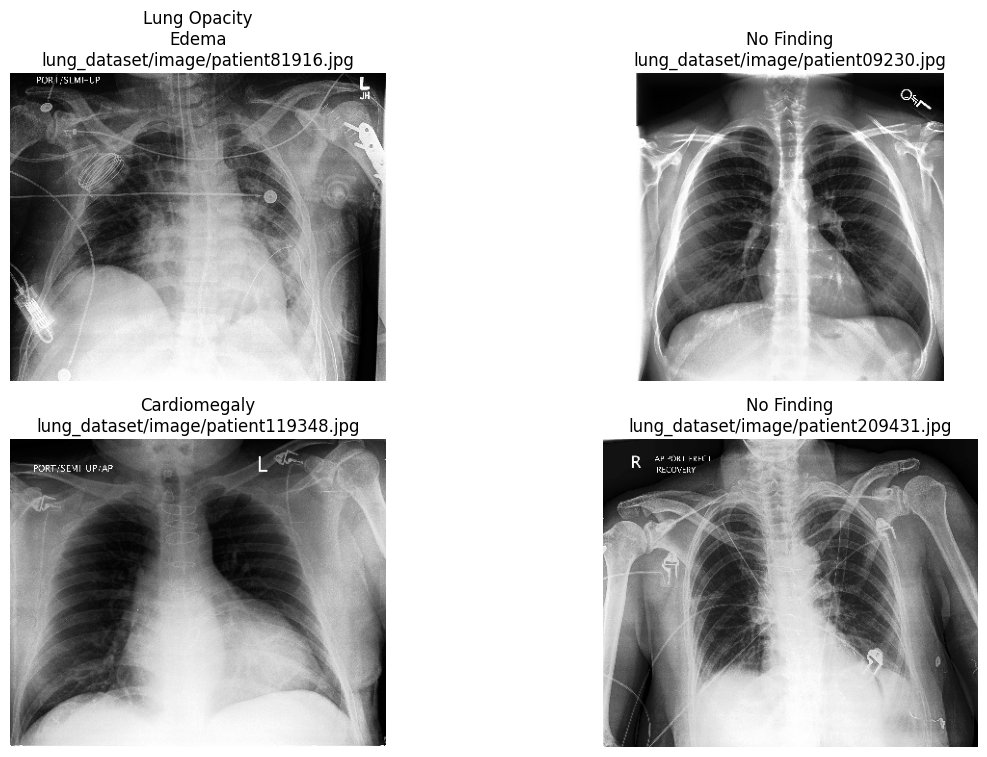

In [139]:
# Pilih sampel acak dari valid_df
samples = random.sample(filtered_train_df, 4)

plt.figure(figsize=(12, 15))
for i, sample in enumerate(samples):
    img_path = sample['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(4, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = ('\n'.join(sample['Labels']) if sample['Labels'] else 'No Finding') + f"\n{sample['Path']}"
    plt.title(title)
plt.tight_layout()
plt.show()

## PROCESING

### Persiapan Label dan Dataset

In [136]:
# Membuat mapping label ke index dan sebaliknya
# label2id = {label: i for i, label in enumerate(label_cols)}
label2id = {label: i for i, label in enumerate(labels_to_keep)}
id2label = {i: label for label, i in label2id.items()}

# Custom Dataset untuk CheXpert multilabel
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform, label2id):
        # dataframe: list of dict {'Path': ..., 'Labels': [...]}
        self.data = list(dataframe)
        self.transform = transform
        self.label2id = label2id

    def __len__(self):
        # Mengembalikan jumlah data
        return len(self.data)

    def __getitem__(self, idx):
        # Ambil path gambar dan label
        image_path = self.data[idx]['Path']
        findings = self.data[idx]['Labels']
        image = Image.open(image_path).convert("RGB")

        # Membuat vektor biner multilabel
        label_vec = torch.zeros(len(self.label2id))
        for finding in findings:
            if finding in self.label2id:
                label_vec[self.label2id[finding]] = 1.0

        # Transformasi gambar jika ada
        if self.transform:
            image = self.transform(image)

        # Kembalikan dictionary sesuai kebutuhan Trainer HuggingFace
        return {"Path": image, "Labels": label_vec}


### Image Processor dan Tokenizer

In [137]:
model_name = "google/vit-base-patch16-224"  # Ganti dengan model yang sesuai
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True,  # This will ignore the classifier head size mismatch
)

def collate_fn(batch):
    pixel_values = torch.stack([item["Path"] for item in batch])
    labels = torch.stack([item["Labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Transformasi Dataset

In [142]:
# Crop tengah dengan hitungan persen (misal: crop 90% area tengah)
class CenterCropPercent:
    def __init__(self, percent):
        self.percent = percent

    def __call__(self, img):
        w, h = img.size
        crop_w, crop_h = int(w * self.percent), int(h * self.percent)
        left = (w - crop_w) // 2
        top = (h - crop_h) // 2
        right = left + crop_w
        bottom = top + crop_h
        return img.crop((left, top, right, bottom))

# Contoh: crop 90% area tengah
train_transform = transforms.Compose([
    CenterCropPercent(0.7),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

# lung_datasets = {
#     "train": CheXpertDataset(train_df, train_transform, label2id),
#     "validation": CheXpertDataset(valid_df, train_transform, label2id)
# }

lung_datasets = {
    "train": CheXpertDataset(filtered_train_df, train_transform, label2id),
    "validation": CheXpertDataset(filtered_valid_df, train_transform, label2id)
}

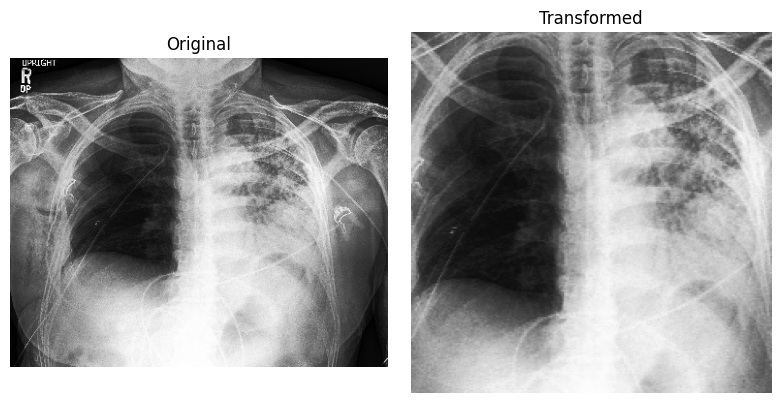

In [144]:
import numpy as np

# Preview hasil transformasi pada satu gambar dari train_df
import matplotlib.pyplot as plt

# sample = train_df[0]
sample = random.choice(filtered_train_df)  # Ambil sampel acak dari train_df
img_path = sample['Path']
original_image = Image.open(img_path).convert("RGB")
transformed_image = train_transform(original_image)

# Convert tensor to numpy for visualization
def tensor_to_image(tensor):
    img = tensor.clone().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW to HWC
    img = img * np.array(processor.image_std) + np.array(processor.image_mean)  # unnormalize
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(transformed_image))
plt.title("Transformed")
plt.axis('off')
plt.tight_layout()
plt.savefig('document/transform_preview.png')
plt.show()

In [145]:
def compute_metrics(pred):
    logits, labels = pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro")
    macro_f1 = f1_score(labels, preds, average="macro")
    accuracy = accuracy_score(labels, preds)

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        #"accuracy": accuracy
    }

### Training

In [146]:
!nvidia-smi

Sun Jul 20 18:15:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:05:00.0 Off |                  N/A |
|  0%   37C    P8              8W /  165W |    2352MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Nama metrik yang digunakan untuk memilih model terbaik
metric_name = "micro_f1"

# Inisialisasi TrainingArguments untuk konfigurasi pelatihan
args = TrainingArguments(
    output_dir="chexpert-vit-model",        # Direktori output untuk menyimpan model
    eval_strategy="steps",                  # Evaluasi dilakukan setiap beberapa langkah
    save_strategy="steps",                  # Model disimpan setiap beberapa langkah
    logging_strategy="steps",
    logging_steps=200,                      # Logging setiap 100 langkah
    save_steps=200,                         # Simpan model setiap 100 langkah
    eval_steps=200,                         # Evaluasi setiap 100 langkah
    #fp16=True,
    learning_rate=1e-5,                     # Learning rate
    lr_scheduler_type="cosine",              # atau linear, polynomial, dll
    #warmup_steps=500,                       # opsional: jumlah langkah warmup
    per_device_train_batch_size=8,          # Batch size untuk training per device
    per_device_eval_batch_size=8,           # Batch size untuk evaluasi per device
    num_train_epochs=50,                       # Jumlah epoch training
    weight_decay=0.01,                         # Weight decay (regularisasi)
    load_best_model_at_end=True,               # Muat model terbaik di akhir training
    metric_for_best_model=metric_name,         # Metrik yang digunakan untuk memilih model terbaik
    logging_dir='logs',                        # Direktori untuk menyimpan log
    remove_unused_columns=False,               # Jangan hapus kolom yang tidak digunakan
    push_to_hub=False,                         # Tidak mengunggah ke Hugging Face Hub
    # hub_model_id="chexpert-vit-multilabel"  # Nama model di Hugging Face Hub (tidak digunakan karena push_to_hub=False)
)

# Inisialisasi Trainer dari HuggingFace
trainer = Trainer(
    model=model,                            # Model yang akan dilatih
    args=args,                              # Argument konfigurasi training
    train_dataset=lung_datasets['train'],   # Dataset training
    eval_dataset=lung_datasets['validation'],# Dataset validasi
    data_collator=collate_fn,               # Fungsi untuk menggabungkan batch data
    compute_metrics=compute_metrics,        # Fungsi untuk menghitung metrik evaluasi
    tokenizer=processor,                     # Image processor/tokenizer
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=10
        )]
)

# Mulai proses training
trainer.train()


/tmp/ipykernel_30/4259957417.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Micro F1,Macro F1
100,0.508900,0.522336,0.023076,0.018407
200,0.461000,0.510220,0.121215,0.082291
300,0.449800,0.498835,0.235101,0.149452
400,0.434300,0.503645,0.190197,0.140188
500,0.411300,0.493953,0.291394,0.185119
600,0.415800,0.494279,0.283195,0.204730
700,0.393600,0.497315,0.292356,0.188954
800,0.405600,0.498182,0.265979,0.176715
900,0.391300,0.492849,0.305146,0.209414
1000,0.387900,0.487880,0.333376,0.236834


TrainOutput(global_step=4100, training_loss=0.3461267196841356, metrics={'train_runtime': 5617.2113, 'train_samples_per_second': 443.85, 'train_steps_per_second': 55.481, 'total_flos': 2.541873944081203e+18, 'train_loss': 0.3461267196841356, 'epoch': 0.6577891865875181})

In [148]:
# Menampilkan plot loss dan accuracy dari hasil training HuggingFace Trainer

# Ambil data training log dari Trainer
training_logs = trainer.state.log_history

# Ekstrak loss dan f1 (accuracy) dari log
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
micro_f1 = []
macro_f1 = []

for log in training_logs:
    if 'loss' in log and 'step' in log:
        train_steps.append(log['step'])
        train_loss.append(log['loss'])
    if 'eval_loss' in log and 'step' in log:
        eval_steps.append(log['step'])
        eval_loss.append(log['eval_loss'])
    if 'eval_micro_f1' in log and 'step' in log:
        micro_f1.append(log['eval_micro_f1'])
    if 'eval_macro_f1' in log and 'step' in log:
        macro_f1.append(log['eval_macro_f1'])

plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss')
plt.plot(eval_steps, eval_loss, label='Eval Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Evaluation Loss')
plt.legend()

# Plot F1 score
plt.subplot(1, 2, 2)
plt.plot(eval_steps, micro_f1, label='Train Accuracy')
plt.plot(eval_steps, macro_f1, label='Eval Accuracy')
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Validation Accuracy (F1)')
plt.legend()

plt.tight_layout()
plt.savefig('document/training_evaluation_plot.png')
plt.show()

: 

In [51]:
import torch

best_model_dir = 'chexpert-vit-model'  # Ensure this variable is defined

pth_path = best_model_dir + "/model_best.pth"
torch.save(model.state_dict(), pth_path)
print(f"Model state_dict telah diekspor ke: {pth_path}")


Model state_dict telah diekspor ke: chexpert-vit-model/model_best.pth


In [52]:
from torchvision import transforms
import torch
from PIL import Image

# Siapkan transformasi sesuai training
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

def predict_image(image_path, model, transform, label2id, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Tambahkan batch dimensi
    device = next(model.parameters()).device
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        logits = outputs.logits
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        pred_labels = [label for label, idx in label2id.items() if probs[idx] > threshold]
    return pred_labels, probs

# Contoh prediksi pada 5 data test_df
for sample in test_df[:5]:
    img_path = sample['Path']
    true_labels = sample['Labels']
    pred_labels, probs = predict_image(img_path, model, test_transform, label2id)
    print(f"Image: {img_path}")
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {pred_labels}")
    print(f"Probabilities: {probs}")
    print('-'*50)

Image: lung_dataset/image/patient190092.jpg
True Labels: ['Cardiomegaly', 'Edema']
Predicted Labels: []
Probabilities: [0.22066133 0.21960664 0.22610384 0.21673116 0.19135988 0.20373629
 0.17630537 0.200425   0.22554314 0.21541442 0.2200329 ]
--------------------------------------------------
Image: lung_dataset/image/patient46078.jpg
True Labels: ['Cardiomegaly']
Predicted Labels: []
Probabilities: [0.22373423 0.21868435 0.221846   0.22380126 0.18364558 0.1998949
 0.18385512 0.19824012 0.22393866 0.20519918 0.22331975]
--------------------------------------------------
Image: lung_dataset/image/patient36414.jpg
True Labels: ['Pleural Effusion']
Predicted Labels: []
Probabilities: [0.22989103 0.21978036 0.2207352  0.2261718  0.18469173 0.19641194
 0.18596356 0.20130704 0.224545   0.20546697 0.22330101]
--------------------------------------------------
Image: lung_dataset/image/patient46513.jpg
True Labels: []
Predicted Labels: []
Probabilities: [0.23072806 0.21812968 0.22419827 0.2260

In [53]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import numpy as np

# Siapkan data ground truth dan prediksi untuk seluruh test set
y_true = []
y_pred = []

# Gunakan transformasi yang sama seperti pada prediksi sebelumnya
for sample in test_df:
    img_path = sample['Path']
    true_labels = sample['Labels']
    pred_labels, _ = predict_image(img_path, model, test_transform, label2id)
    # Buat vektor biner untuk true dan prediksi
    true_vec = np.zeros(len(label2id))
    pred_vec = np.zeros(len(label2id))
    for label in true_labels:
        if label in label2id:
            true_vec[label2id[label]] = 1
    for label in pred_labels:
        if label in label2id:
            pred_vec[label2id[label]] = 1
    y_true.append(true_vec)
    y_pred.append(pred_vec)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Tampilkan classification report per label
print(classification_report(
    y_true, y_pred, target_names=label2id.keys(), zero_division=0
))

                            precision    recall  f1-score   support

Enlarged Cardiomediastinum       0.00      0.00      0.00      1294
              Cardiomegaly       0.00      0.00      0.00      3140
              Lung Opacity       0.00      0.00      0.00      9783
               Lung Lesion       0.00      0.00      0.00       909
                     Edema       0.00      0.00      0.00      6919
             Consolidation       0.00      0.00      0.00      1554
                 Pneumonia       0.00      0.00      0.00       618
               Atelectasis       0.00      0.00      0.00      4338
              Pneumothorax       0.00      0.00      0.00      2765
          Pleural Effusion       0.00      0.00      0.00     10042
                  Fracture       0.00      0.00      0.00      1017

                 micro avg       0.00      0.00      0.00     42379
                 macro avg       0.00      0.00      0.00     42379
              weighted avg       0.00      0.0

# **HIDUP JOKOWI ! ✊** 